# Computer Vision with Transformers


In this notebook, we use the Hugging Face Transformers library to process images. To avoid overloading the notebook, some functions are located in utils/util.py.


## Zero-Shot Object Detection


Object detection in an image is a key task in computer vision. Zero-shot models are very practical as they detect any object without the need for fine-tuning. Simply provide them with an image and a text prompt containing the classes to detect.


### Implementation


We chose Google's OWL-ViT model (google/owlvit-base-patch32) as it is compact and works on most machines. Let's use Hugging Face's pipeline:


In [1]:
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

zeroshot = pipeline("zero-shot-object-detection", model="google/owlvit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's take a look at our image.


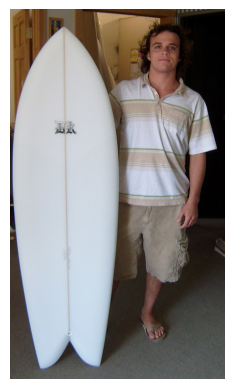

In [119]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

Let's use the model to draw the predicted detection boxes.


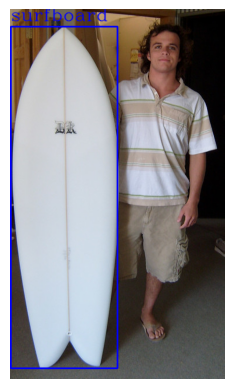

In [120]:
from utils.util import draw_box

text_prompt = "surfboard" # Vous pouvez changer la classe pour détecter autre chose "person" ou "surfboard"
output = zeroshot(image,candidate_labels = [text_prompt])
cv_image=draw_box(image,output)

plt.imshow(cv_image)
plt.axis('off') 
plt.show()

You now know how to implement a zero-shot object detector in just a few lines of code.


## Image Captioning


Image captioning involves generating a description for an image. The model takes an image as input and produces a caption.


### Implementation


As before, we use Hugging Face's pipeline. Here, we use Salesforce's BLIP model (Salesforce/blip-image-captioning-base).


In [121]:
captionner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

We use the same image to generate a description.


In [122]:
result=captionner(image)
print(result[0]['generated_text'])

a man holding a surfboard in a room


We generated the description "a man holding a surfboard in a room," which is accurate. You now know how to generate image descriptions. This is very useful for automatically creating datasets, for example.


## Zero-Shot Image Classification


In addition to zero-shot object detection, we can perform zero-shot image classification. The principle is similar, but this time we provide at least two phrases, and the model gives us the probability that the image corresponds to one or the other.


### Implementation


Let's use a photo of my cat to determine its breed:


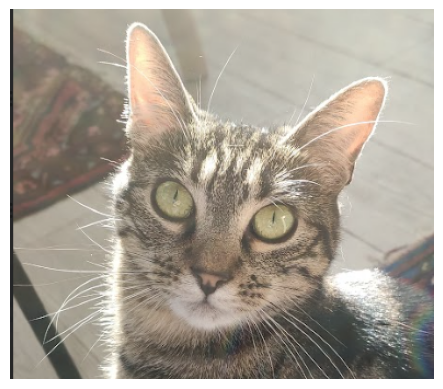

In [123]:
image=Image.open("images/tigrou.png") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

Let's see if the model can determine whether it is a Maine Coon or a European shorthair cat.


We use OpenAI's CLIP model (openai/clip-vit-base-patch32). For variety, we use other functions from the Hugging Face library instead of the pipeline.


In [125]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [133]:
labels = ["a photo of a european shorthair", "a photo of maine coon"]
inputs = processor(text=labels,images=image,return_tensors="pt",padding=True)
outputs = model(**inputs)

# Transformation des outputs pour obtenir des probabilités
print("Probabilité de a photo of a european shorthair : ",outputs.logits_per_image.softmax(dim=1)[0][0].item())
print("Probabilité de a photo of maine coon : ",outputs.logits_per_image.softmax(dim=1)[0][1].item())

Probabilité de a photo of a european shorthair :  0.9104425311088562
Probabilité de a photo of maine coon :  0.08955750614404678


The model is quite confident that it is a European shorthair cat, and indeed, it is correct.


## Image Segmentation


For this example, we use Meta's SAM model, which allows segmenting any object.


### Implementation


In [2]:
sam = pipeline("mask-generation","Zigeng/SlimSAM-uniform-77")

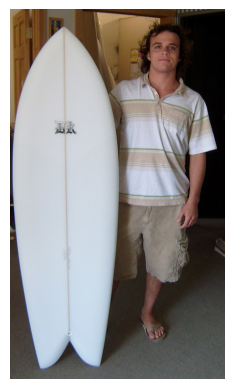

In [3]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [8]:
# ATTENTION : le traitement peut prendre plusieurs minutes
output=sam(image, points_per_batch=32)

In [5]:
masks=output["masks"]

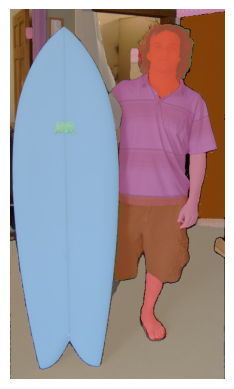

In [7]:
from utils.util import draw_masks
image_np=draw_masks(image,masks)

plt.imshow(image_np)
plt.axis('off') 
plt.show()

As you can see, we segmented all objects in the image. However, the processing time was quite long... For a more reasonable inference time, we use a coordinate prompt of a point in the image. This allows specifying the processing and obtaining a result more quickly. We cannot use the pipeline for this task.


In [9]:
from transformers import SamModel, SamProcessor

In [10]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

Let's create our coordinate prompt and visualize the point:


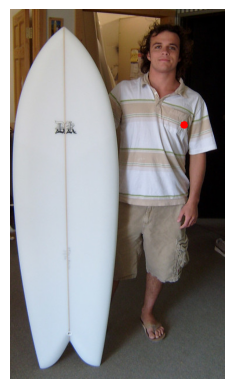

In [41]:
input_points = [[[300, 200]]]
image_np= np.array(image)
cv2.circle(image_np,input_points[0][0],radius=3,color=(255,0,0),thickness=5)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [44]:
inputs = processor(image,input_points=input_points,return_tensors="pt")
outputs = model(**inputs)
predicted_masks = processor.image_processor.post_process_masks(
  outputs.pred_masks,
  inputs["original_sizes"],
  inputs["reshaped_input_sizes"]
)

The processing is much faster! SAM produces 3 masks by default. Each mask represents a possible segmentation of the image. You can change the **mask_number** value to visualize the different masks.


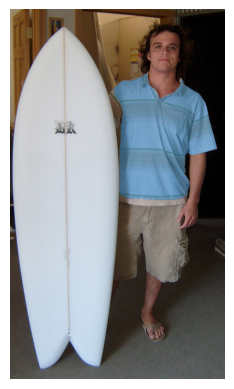

In [46]:
mask_number=2 # 0,1 or 2
mask=predicted_masks[0][:, mask_number] 
image_np=draw_masks(image,mask)
plt.imshow(image_np)
plt.axis('off') 
plt.show()

In this example, we see that the 3 masks are relevant: the first segments the entire person, the second segments the clothes, and the third segments only the t-shirt. You can try changing the point coordinates and visualizing the generated masks.


## Depth Estimation


Depth estimation is a key task in computer vision. It is very useful for applications like autonomous vehicles, where we estimate the distance to the vehicle in front of us. For industry, it is also interesting for organizing objects in a package based on the remaining space. For this example, we use the DPT model (Intel/dpt-hybrid-midas), which takes an image as input and returns a depth map.


### Implementation


In [47]:
depth_estimator = pipeline(task="depth-estimation",model="Intel/dpt-hybrid-midas")

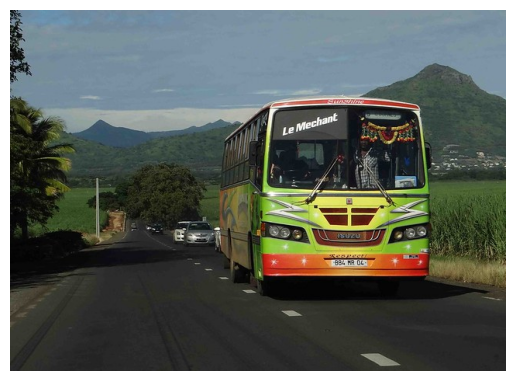

In [48]:
image=Image.open("images/coco2.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [57]:
outputs = depth_estimator(image)
outputs["predicted_depth"].shape

torch.Size([1, 384, 384])

We use PyTorch to adjust the dimension of the predicted depth map to that of our base image, then we generate an image of the depth map.


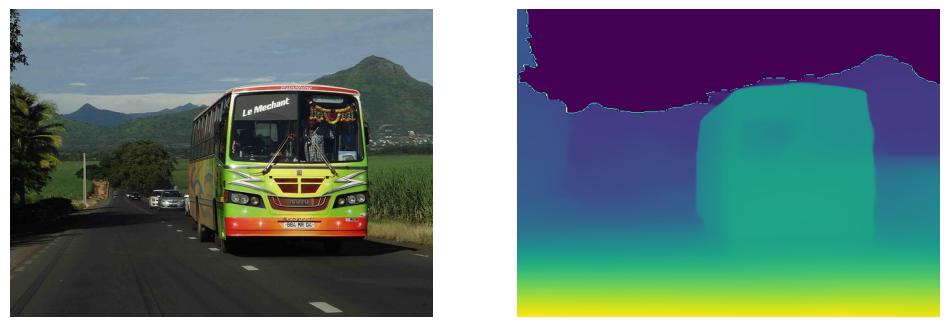

In [60]:
import torch 
prediction = torch.nn.functional.interpolate(outputs["predicted_depth"].unsqueeze(1),size=image.size[::-1],
                                             mode="bicubic",align_corners=False)
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.imshow(image)
ax1.axis('off')  
ax2.imshow(depth)
ax2.axis('off')  
plt.show()

On the depth map, bright colors represent the closest objects. We can clearly see the nearby road in very bright color and the bus in quite bright color. The depth map is therefore accurate.
